<a href="https://colab.research.google.com/github/thanmayeev135/Pattern-Sense-Classifying-Fabric-Patterns-using-Deep-Learning./blob/main/fabric_pattern_sense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
  inflating: data_pattern/animal/3280.jpg  
  inflating: data_pattern/animal/3281.jpg  
  inflating: data_pattern/animal/3282.jpg  
  inflating: data_pattern/animal/3283.jpg  
  inflating: data_pattern/animal/3284.jpg  
  inflating: data_pattern/animal/3285.jpg  
  inflating: data_pattern/animal/3286.jpg  
  inflating: data_pattern/animal/3287.jpg  
  inflating: data_pattern/animal/3288.jpg  
  inflating: data_pattern/animal/3289.jpg  
  inflating: data_pattern/animal/3290.jpg  
  inflating: data_pattern/animal/3291.jpg  
  inflating: data_pattern/animal/3292.jpg  
  inflating: data_pattern/animal/3293.jpg  
  inflating: data_pattern/animal/3294.jpg  
  inflating: data_pattern/animal/3295.jpg  
  inflating: data_pattern/animal/3296.jpg  
  inflating: data_pattern/animal/3297.jpg  
  inflating: data_pattern/animal/3298.jpg  
  inflating: data_pattern/animal/3299.jpg  
  inflating: data_pattern/animal/3300.jpg  
  inflating: data_pattern/anima

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import os
import matplotlib.pyplot as plt

In [ ]:
def read_data(folder):
    labels, paths = [], []
    classes = os.listdir(folder)
    for label in classes:
        path = os.path.join(folder, label)
        if not os.path.isdir(path):
            continue
        for image_path in os.listdir(path):
            labels.append(label)
            paths.append(os.path.join(path, image_path))
    return labels, paths

In [ ]:
directory = '/content/data_pattern'
all_labels, all_paths = read_data(directory)

In [ ]:
df=pd.DataFrame({
    'path':all_paths,
    'label':all_labels
})

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df,dummy_df=train_test_split(df,train_size=0.8,random_state=123,shuffle=True,stratify=df['label'])
valid_df,test_df=train_test_split(dummy_df,train_size=0.5,random_state=123,shuffle=True,stratify=dummy_df['label'])
print("Train dataset:",len(train_df),"Test dataset:",len(test_df),"Validation dataset:",len(valid_df))
train_balance=train_df['label'].value_counts()
print('Train dataset value count: \n',train_df['label'].value_counts())

Train dataset: 3384 Test dataset: 423 Validation dataset: 423
Train dataset value count: 
 label
stripes      400
polka dot    398
plain        398
tribal       397
floral       396
squares      351
ikat         284
animal       281
geometry     271
cartoon      208
Name: count, dtype: int64


In [ ]:
directory='/content/data_pattern'

In [ ]:
labels=os.listdir(directory)
labels

['floral',
 'animal',
 'squares',
 'tribal',
 'plain',
 'ikat',
 'geometry',
 'polka dot',
 'cartoon',
 'stripes']

In [ ]:
labels.sort()

Data Augumentation

In [ ]:
import cv2
import numpy as np

In [ ]:
def apply_transform(image):
  angle=np.random.uniform(-40,40)
  rows,cols=image.shape[:2]
  M=cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
  image=cv2.warpAffine(image,M(cols,rows))
  if np.random.rand()<0.5:
    image=cv2.flip(image,1)
  if np.random.rand()<0.5:
    image=cv2.flip(image,0)
  alpha=1.0+np.random.uniform(-0.2,0.2)
  beta=0.0+np.random.uniform(-0.2,0.2)
  image=cv2.convertScaleAbs(image,alpha=alpha,beta=0)
  gamma=np.random.uniform(0.8,1.2)
  image=np.clip((image/255.0)**gamma,0,1)*255.0
  return image

In [ ]:
def apply_agumentation(image_path,label):
  image=cv2.imread(image_path)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  augumented_image=apply_transform(image=image)
  return augumented_image,label

image preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
gen=ImageDataGenerator()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen=gen.flow_from_dataframe(train_df,x_col='path',y_col='label',target_size=(255,255),seed=123,class_mode='categorical',color_mode='rgb',shuffle=True,batch_size=32)

Found 3384 validated image filenames belonging to 10 classes.


In [ ]:
valid_gen=gen.flow_from_dataframe(valid_df,x_col='path',y_col='label',target_size=(255,255),seed=123,class_mode='categorical',color_mode='rgb',shuffle=False,batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


In [ ]:
test_gen=gen.flow_from_dataframe(test_df,x_col='path',y_col='label',target_size=(255,255),seed=123,class_mode='categorical',color_mode='rgb',shuffle=False,batch_size=32)

Found 423 validated image filenames belonging to 10 classes.


Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,BatchNormalization
from keras.layers import Convolution2D,MaxPooling2D
from keras import regularizers
from keras.models import Model
from keras .optimizers import Adam,Adamax
import tensorflow as tf

In [ ]:
model=Sequential()
model.add(Convolution2D(filters=32,kernel_size=3,input_shape=(255,255,3),activation='relu',padding='same'))
model.add(MaxPooling2D(strides=2,pool_size=2,padding="valid"))
model.add(Convolution2D(filters=32,kernel_size=2,activation='relu',padding='same'))
model.add(MaxPooling2D(strides=2,pool_size=2,padding="valid"))
model.add(Dropout(0.5))
model.add(Convolution2D(filters=32,kernel_size=2,activation='relu',padding='same'))
model.add(MaxPooling2D(strides=2,pool_size=2,padding="valid"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 127, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,826 (15.06 MB)

 Trainable params: 3,946,826 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath='model_cnn.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history_cnn=model.fit(x=train_gen,epochs=40,verbose=1,validation_data=valid_gen,validation_steps=None,shuffle=True,callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1150 - loss: 2.7636
Epoch 1: val_accuracy improved from -inf to 0.22931, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.1151 - loss: 2.7603 - val_accuracy: 0.2293 - val_loss: 2.2804
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1633 - loss: 2.2675
Epoch 2: val_accuracy did not improve from 0.22931
106/106 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.1633 - loss: 2.2675 - val_accuracy: 0.2009 - val_loss: 2.2465
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1904 - loss: 2.2385
Epoch 3: val_accuracy did not improve from 0.22931
106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.1903 - loss: 2.2385 - val_accuracy: 0.1915 - val_loss: 2.1869
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2007 - loss: 2.1946
Epoch 4: val_accuracy did not improve from 0.22931
106/106 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.2007 - loss: 2.1945 - val_accuracy: 0.2293 - val_loss: 2.1461
Epoch 5/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1821 - loss: 2.1673
Epoch 5: val_accuracy improved from

106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.1822 - loss: 2.1671 - val_accuracy: 0.2364 - val_loss: 2.1465
Epoch 6/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2168 - loss: 2.1185
Epoch 6: val_accuracy improved from 0.23641 to 0.27660, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.2168 - loss: 2.1185 - val_accuracy: 0.2766 - val_loss: 2.0823
Epoch 7/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2469 - loss: 2.0597
Epoch 7: val_accuracy improved from 0.27660 to 0.28369, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.2469 - loss: 2.0598 - val_accuracy: 0.2837 - val_loss: 2.0453
Epoch 8/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2473 - loss: 2.0490
Epoch 8: val_accuracy did not improve from 0.28369
106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.2473 - loss: 2.0490 - val_accuracy: 0.2553 - val_loss: 2.0363
Epoch 9/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2700 - loss: 1.9782
Epoch 9: val_accuracy did not improve from 0.28369
106/106 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.2700 - loss: 1.9783 - val_accuracy: 0.2837 - val_loss: 2.0334
Epoch 10/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2664 - loss: 1.9767
Epoch 10: val_accuracy improved from 0.28369 to 0.28842, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.2664 - loss: 1.9768 - val_accuracy: 0.2884 - val_loss: 2.0109
Epoch 11/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2912 - loss: 1.9055
Epoch 11: val_accuracy improved from 0.28842 to 0.29551, saving model to model_cnn.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.2912 - loss: 1.9056 - val_accuracy: 0.2955 - val_loss: 2.0000
Epoch 12/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2958 - loss: 1.8969
Epoch 12: val_accuracy did not improve from 0.29551
106/106 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.2957 - loss: 1.8970 - val_accuracy: 0.2837 - val_loss: 2.0009
Epoch 13/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3060 - loss: 1.8545
Epoch 13: val_accuracy did not improve from 0.29551
106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3059 - loss: 1.8547 - val_accuracy: 0.2766 - val_loss: 2.0047
Epoch 14/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3090 - loss: 1.8349
Epoch 14: val_accuracy did not improve from 0.29551
106/106 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.3090 - loss: 1.8350 - val_accuracy: 0.2908 - val_loss: 1.9691
Epoch 15/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3363 - loss: 1.7679
Epoch 15: val_accuracy did n

106/106 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3266 - loss: 1.7996 - val_accuracy: 0.3333 - val_loss: 1.9901
Epoch 17/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3495 - loss: 1.7414
Epoch 17: val_accuracy did not improve from 0.33333
106/106 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3495 - loss: 1.7415 - val_accuracy: 0.3026 - val_loss: 1.9901
Epoch 18/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3542 - loss: 1.6960
Epoch 18: val_accuracy did not improve from 0.33333
106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3543 - loss: 1.6960 - val_accuracy: 0.2908 - val_loss: 1.9672
Epoch 19/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3602 - loss: 1.7047
Epoch 19: val_accuracy did not improve from 0.33333
106/106 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.3604 - loss: 1.7044 - val_accuracy: 0.2861 - val_loss: 2.0368
Epoch 20/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3825 - loss: 1.6531
Epoch 20: val_accuracy did n

In [ ]:
base_model=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(255,255,3))
print('Created ResNet50 model')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Created ResNet50 model


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
for layer in base_model.layers[173:]:
  layer.trainable=True

In [ ]:
x1=base_model.output
x2=tf.keras.layers.GlobalAveragePooling2D()(x1)

In [ ]:
x3=tf.keras.layers.Dense(1024,activation='relu',kernel_initializer="he_uniform")(x2)
x4=tf.keras.layers.Dropout(0.4)(x3)
x5=tf.keras.layers.Dense(512,activation='relu',kernel_initializer="he_uniform")(x4)

In [ ]:
predictions=tf.keras.layers.Dense(10,activation='softmax')(x5)

In [ ]:
final_model =tf.keras.models.Model(inputs=base_model.input,outputs=predictions)

In [ ]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_checkpoint_callback_rs=tf.keras.callbacks.ModelCheckpoint(
    filepath='model_50.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history_resnet=final_model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[model_checkpoint_callback_rs])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1259 - loss: 2.6739
Epoch 1: val_accuracy improved from -inf to 0.22459, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 924s 9s/step - accuracy: 0.1262 - loss: 2.6713 - val_accuracy: 0.2246 - val_loss: 2.1890
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1870 - loss: 2.1978
Epoch 2: val_accuracy did not improve from 0.22459
106/106 ━━━━━━━━━━━━━━━━━━━━ 971s 9s/step - accuracy: 0.1871 - loss: 2.1977 - val_accuracy: 0.2151 - val_loss: 2.1643
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2186 - loss: 2.1543
Epoch 3: val_accuracy improved from 0.22459 to 0.26005, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 955s 9s/step - accuracy: 0.2186 - loss: 2.1543 - val_accuracy: 0.2600 - val_loss: 2.0868
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2259 - loss: 2.1261
Epoch 4: val_accuracy improved from 0.26005 to 0.27660, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 956s 9s/step - accuracy: 0.2260 - loss: 2.1259 - val_accuracy: 0.2766 - val_loss: 2.0730
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2411 - loss: 2.0972
Epoch 5: val_accuracy did not improve from 0.27660
106/106 ━━━━━━━━━━━━━━━━━━━━ 956s 9s/step - accuracy: 0.2410 - loss: 2.0973 - val_accuracy: 0.2719 - val_loss: 2.0527
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2338 - loss: 2.1114
Epoch 6: val_accuracy improved from 0.27660 to 0.27896, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.2339 - loss: 2.1112 - val_accuracy: 0.2790 - val_loss: 2.0283
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2622 - loss: 2.0764
Epoch 7: val_accuracy did not improve from 0.27896
106/106 ━━━━━━━━━━━━━━━━━━━━ 952s 9s/step - accuracy: 0.2621 - loss: 2.0764 - val_accuracy: 0.2624 - val_loss: 2.0712
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2776 - loss: 2.0432
Epoch 8: val_accuracy improved from 0.27896 to 0.29551, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 913s 9s/step - accuracy: 0.2773 - loss: 2.0434 - val_accuracy: 0.2955 - val_loss: 2.0372
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2544 - loss: 2.0674
Epoch 9: val_accuracy improved from 0.29551 to 0.30733, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 909s 9s/step - accuracy: 0.2544 - loss: 2.0673 - val_accuracy: 0.3073 - val_loss: 2.0259
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2543 - loss: 2.0584
Epoch 10: val_accuracy did not improve from 0.30733
106/106 ━━━━━━━━━━━━━━━━━━━━ 903s 9s/step - accuracy: 0.2544 - loss: 2.0584 - val_accuracy: 0.2790 - val_loss: 2.0141
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2502 - loss: 2.0573
Epoch 11: val_accuracy did not improve from 0.30733
106/106 ━━━━━━━━━━━━━━━━━━━━ 950s 9s/step - accuracy: 0.2503 - loss: 2.0572 - val_accuracy: 0.2979 - val_loss: 2.0141
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2700 - loss: 2.0494
Epoch 12: val_accuracy did not improve from 0.30733
106/106 ━━━━━━━━━━━━━━━━━━━━ 909s 9s/step - accuracy: 0.2700 - loss: 2.0494 - val_accuracy: 0.2979 - val_loss: 1.9784
Epoch 13/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2826 - loss: 2.0129
Epoch 13: val_accuracy did n

106/106 ━━━━━━━━━━━━━━━━━━━━ 954s 9s/step - accuracy: 0.2962 - loss: 1.9973 - val_accuracy: 0.3121 - val_loss: 1.9481
Epoch 18/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2907 - loss: 1.9933
Epoch 18: val_accuracy did not improve from 0.31206
106/106 ━━━━━━━━━━━━━━━━━━━━ 936s 9s/step - accuracy: 0.2906 - loss: 1.9935 - val_accuracy: 0.2979 - val_loss: 1.9597
Epoch 19/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2855 - loss: 2.0062
Epoch 19: val_accuracy improved from 0.31206 to 0.31915, saving model to model_50.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 897s 8s/step - accuracy: 0.2854 - loss: 2.0063 - val_accuracy: 0.3191 - val_loss: 1.9983
Epoch 20/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2627 - loss: 2.0493
Epoch 20: val_accuracy did not improve from 0.31915
106/106 ━━━━━━━━━━━━━━━━━━━━ 897s 8s/step - accuracy: 0.2627 - loss: 2.0491 - val_accuracy: 0.2979 - val_loss: 1.9564


Evaluating the model

In [ ]:
import matplotlib.pyplot as plt

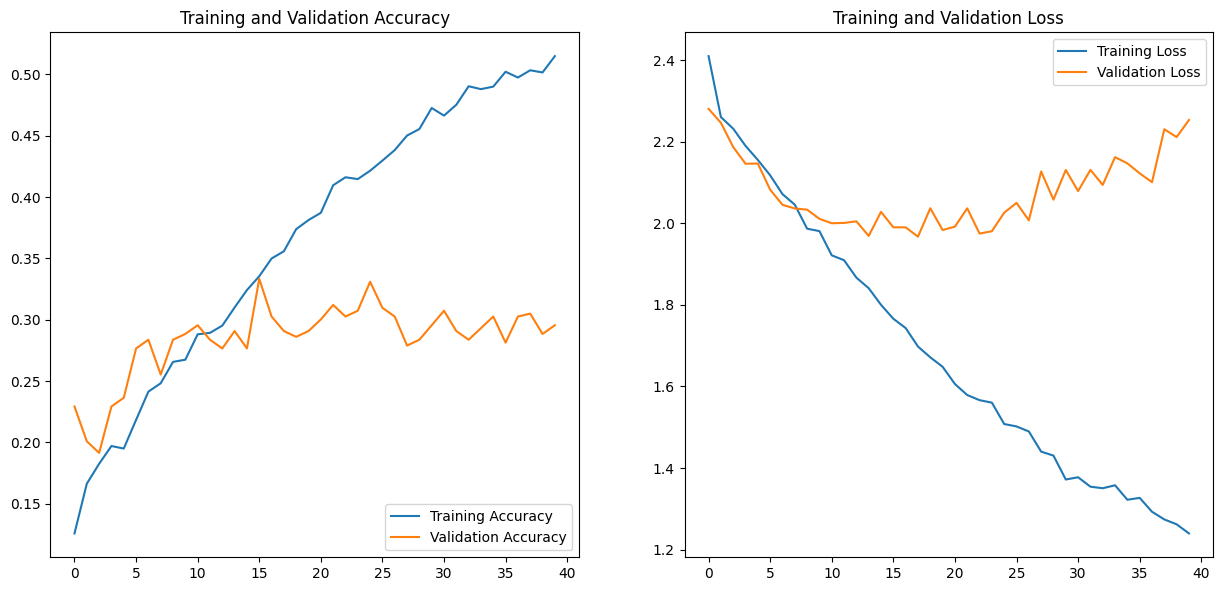

In [ ]:
acc=history_cnn.history['accuracy']
val_acc=history_cnn.history['val_accuracy']
loss=history_cnn.history['loss']
val_loss=history_cnn.history['val_loss']
epochs_range=range(40)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predictor(model,test_gen):
  classes=list(test_gen.class_indices.keys())
  class_count=len(classes)
  preds=model.predict(test_gen,verbose=1)
  errors=0
  pred_indices=[]
  test_count=len(preds)
  for i,p in enumerate(preds):
    pred_index=np.argmax(p)
    pred_indices.append(pred_index)
    true_index=test_gen.labels[i]
    if pred_index!=true_index:
      errors+=1
  accuracy=(test_count-errors)*100/test_count
  ytrue=np.array(test_gen.labels,dtype='int')
  ypred=np.array(pred_indices,dtype='int')
  msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}'
  print(msg)
  cm=confusion_matrix(ytrue,ypred)
  plt.figure(figsize=(20,20))
  sns.heatmap(cm,annot=True,vmin=0,fmt='g',cmap='Blues',cbar=False)
  plt.xticks(np.arange(class_count)+0.5,classes,rotation=90)
  plt.yticks(np.arange(class_count)+0.5,classes,rotation=0)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()
  clr=classification_report(ytrue,ypred,target_names=classes,digits=4)
  print("Classification Report:\n-------------------\n",clr)
  return

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [ ]:
def get_model_prediction(image_path):
  img=load_img(image_path,target_size=(255,255))
  x=img_to_array(img)
  x=np.expand_dims(x,axis=0)
  predictions=model.predict(x,verbose=0)
  return labels[predictions.argmax()]

In [ ]:
pred=[]
for file in test_df['path'].values:
  pred.append(get_model_prediction(file))

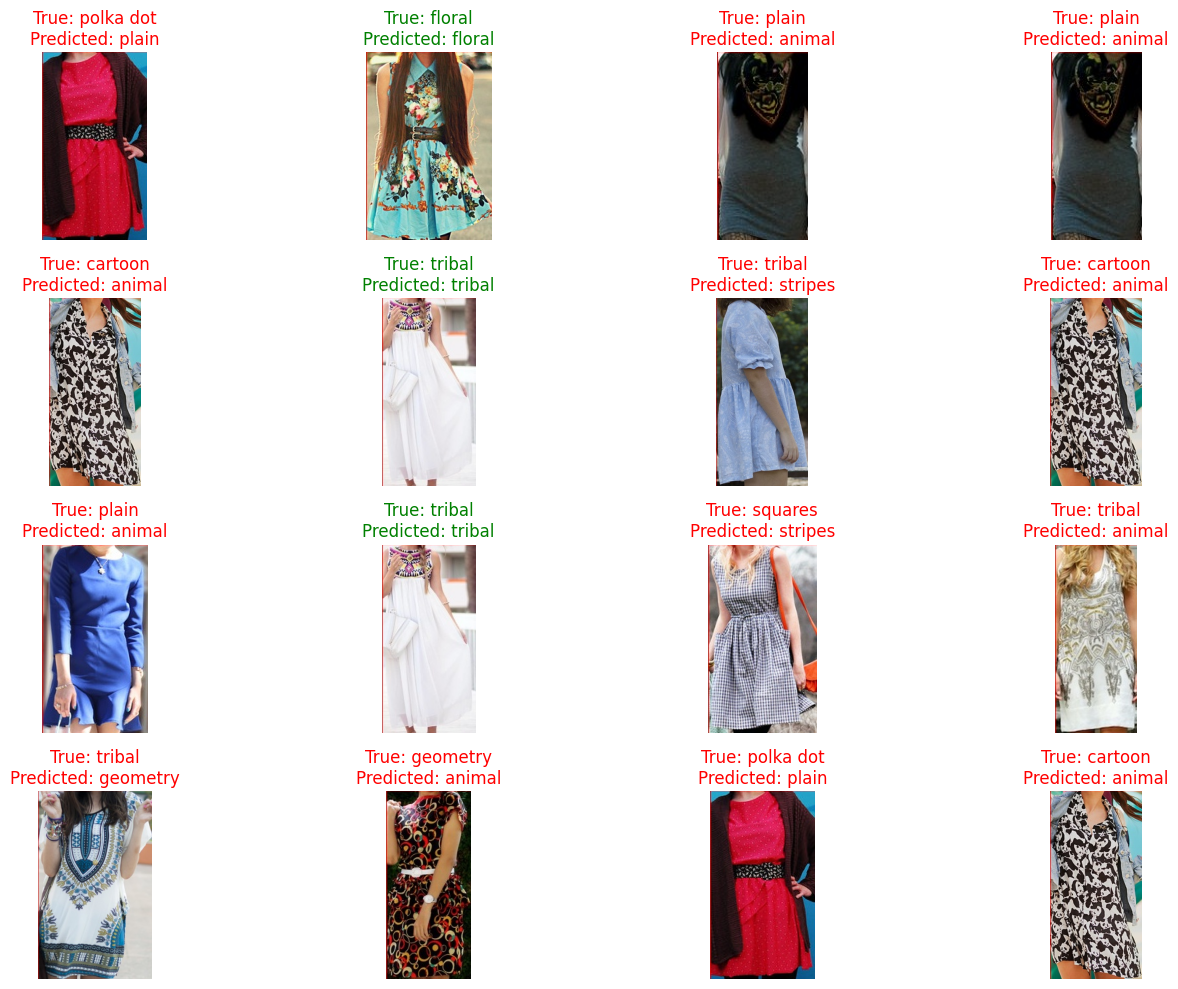

In [ ]:
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(15,10))
random_index=np.random.randint(0,len(test_gen),16)
for i,ax in enumerate(axes.ravel()):
  img_path=test_df['path'].iloc[random_index[i]]
  ax.imshow(load_img(img_path))
  ax.axis('off')
  if test_df['label'].iloc[random_index[i]]==pred[random_index[i]]:
    color="green"
  else:
    color="red"
  ax.set_title(f"True: {test_df['label'].iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}",color=color)
plt.tight_layout()
plt.show()